# Intelligent systems - Assignment 2: Text Classification

## Data preparation and exploration

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Uporabnik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Uporabnik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Uporabnik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Uporabnik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load data and extract basic information

In [6]:
file_path = 'dataset.jsonl'
df = pd.read_json(file_path, lines=True)

In [7]:
missing_values = df.isnull().sum()
print("Missing values per column:\n")
print(missing_values)

Missing values per column:

text     0
label    0
dtype: int64


Class distribution:

label
1    1703
0    1443
3     671
4     584
2     401
5     198
Name: count, dtype: int64


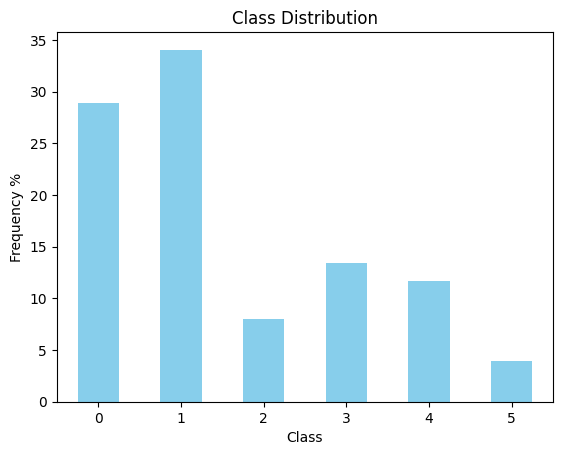

In [8]:
class_distribution = df['label'].value_counts()
print("Class distribution:\n")
print(class_distribution)
class_distribution = class_distribution / np.sum(class_distribution) * 100
class_distribution.sort_index().plot(kind='bar', color='skyblue')
plt.xticks(rotation=0)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency %')
plt.show()

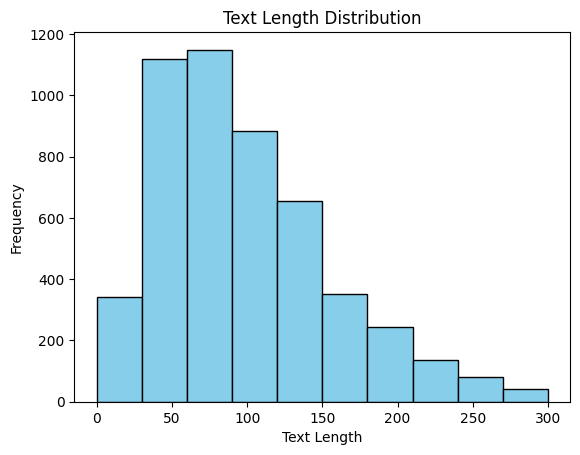

In [9]:
df['text_length'] = df['text'].apply(len)
bins = np.linspace(0, 300, 11)

plt.hist(df['text_length'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### Split data

In [10]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=17)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=17)

print("Data split sizes:\n")
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Data split sizes:

Train set: 3500
Validation set: 750
Test set: 750


### Transform data for machine learning

In [11]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    words = word_tokenize(text.lower())

    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    stemmed_words = [stemmer.stem(word) for word in words]

    preprocessed_text = ' '.join(lemmatized_words)
    
    return preprocessed_text

In [12]:
train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [13]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

## Basic machine learning

In [14]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Classification accuracy: {accuracy:.3f}")
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 score: {f1:.3f}")
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return accuracy, f1, cm

### Decision tree

In [15]:
dt = DecisionTreeClassifier(random_state=17)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

dt_accuracy, dt_f1, dt_cm = evaluate_model(y_test, y_pred, "Decision Tree")

Classification accuracy: 0.873
F1 score: 0.852


### Naive Bayes

In [16]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

y_pred = naive_bayes.predict(X_test)

nb_accuracy, nb_f1, nb_cm = evaluate_model(y_test, y_pred, "Naive Bayes")

Classification accuracy: 0.699
F1 score: 0.498


### Support vector machine

In [17]:
svm = SVC(kernel='linear', class_weight='balanced', random_state=17)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm_accuracy, svm_f1, svm_cm = evaluate_model(y_test, y_pred, "SVM")

Classification accuracy: 0.861
F1 score: 0.831


### Random forest classifier

In [18]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=17, bootstrap=False)
rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_test)

rf_accuracy, rf_f1, rf_cm = evaluate_model(y_test, rf_preds, "Random Forest")

Classification accuracy: 0.873
F1 score: 0.846


### Hyperparameter tuning

In [19]:
dt_param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 20],
    'bootstrap': [True, False]
}

dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)

svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False, random_state=17),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 5, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [20]:
best_dt_model = dt_grid_search.best_estimator_
best_svm_model = svm_grid_search.best_estimator_
best_rf_model = rf_grid_search.best_estimator_

dt_preds = best_dt_model.predict(X_test)
svm_preds = best_svm_model.predict(X_test)
rf_preds = best_rf_model.predict(X_test)

dt_tuned_accuracy, dt_tuned_f1, dt_tuned_cm = evaluate_model(y_test, dt_preds, "Decision Tree (Optimized)")
svm_tuned_accuracy, svm_tuned_f1, svm_tuned_cm = evaluate_model(y_test, svm_preds, "SVM (Optimized)")
rf_tuned_accuracy, rf_tuned_f1, rf_tuned_cm = evaluate_model(y_test, rf_preds, "Random Forest (Optimized)")

Classification accuracy: 0.880
F1 score: 0.858
Classification accuracy: 0.861
F1 score: 0.831
Classification accuracy: 0.873
F1 score: 0.846


## Advanced machine learning

### Larger dataset

In [21]:
ds = load_dataset("dair-ai/emotion", "unsplit")
ds = ds['train'].to_pandas()
ds = ds.sample(50000, replace=True)
ds['text'] = ds['text'].apply(preprocess_text)


In [46]:
train_ds, temp_ds = train_test_split(ds, test_size=0.3, random_state=17, stratify=ds['label'])
val_ds, test_ds = train_test_split(temp_ds, test_size=0.5, random_state=17, stratify=temp_ds['label'])

vectorizer = CountVectorizer()
X_train_big = vectorizer.fit_transform(train_ds['text'])
X_val_big = vectorizer.transform(val_ds['text'])
X_test_big = vectorizer.transform(test_ds['text'])

y_train_big = train_ds['label'].values
y_val_big = val_ds['label'].values
y_test_big = test_ds['label'].values

In [23]:
dt_big = DecisionTreeClassifier(random_state=17)
dt_big.fit(X_train_big, y_train_big)

y_pred_big = dt_big.predict(X_test_big)

dt_big_accuracy, dt_big_f1, dt_big_cm = evaluate_model(y_test_big, y_pred_big, "Decision Tree (Large Dataset)")

Classification accuracy: 0.882
F1 score: 0.845


In [24]:
nb_big = MultinomialNB()
nb_big.fit(X_train_big, y_train_big)

y_pred_big = nb_big.predict(X_test_big)

nb_big_accuracy, nb_big_f1, nb_big_cm = evaluate_model(y_test_big, y_pred_big, "Naive Bayes (Large Dataset)")

Classification accuracy: 0.837
F1 score: 0.725


In [25]:
svm_big = SVC(kernel='linear', class_weight='balanced', random_state=17)
svm_big.fit(X_train_big, y_train_big)

y_pred_big = svm_big.predict(X_test_big)

svm_big_accuracy, svm_big_f1, svm_big_cm = evaluate_model(y_test_big, y_pred_big, "SVM (Large Dataset)")

Classification accuracy: 0.896
F1 score: 0.862


In [26]:
rf_clf_big = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=17, bootstrap=False)
rf_clf_big.fit(X_train_big, y_train_big)

rf_preds_big = rf_clf_big.predict(X_test_big)

rf_accuracy_big, rf_f1_big, rf_cm_big = evaluate_model(y_test_big, rf_preds_big, "Random Forest (Large Dataset)")

Classification accuracy: 0.900
F1 score: 0.863


### Ensamble models

#### Bagging

In [27]:
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None, random_state=17),
    n_estimators=40,
    random_state=17
)

bagging_clf.fit(X_train_big, y_train_big)

bagging_preds = bagging_clf.predict(X_test_big)

bagging_accuracy, bagging_f1, bagging_cm = evaluate_model(y_test_big, bagging_preds, "Bagging Classifier")

Classification accuracy: 0.892
F1 score: 0.858


#### Voting

In [28]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=17, bootstrap=False)
svm = SVC(kernel='linear', class_weight='balanced', random_state=17)
naive_bayes = MultinomialNB()

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('svm', svm), ('naive_bayes', naive_bayes)],
    voting='hard'
)

voting_clf.fit(X_train_big, y_train_big)

voting_preds = voting_clf.predict(X_test_big)

voting_accuracy, voting_f1, voting_cm = evaluate_model(y_test_big, voting_preds, "Voting Classifier")

Classification accuracy: 0.901
F1 score: 0.862


#### Stacking

In [29]:
dt = DecisionTreeClassifier(random_state=17)
svm = SVC(kernel='linear', class_weight='balanced', random_state=17)

stacking_clf = StackingClassifier(
    estimators=[('dt', dt), ('svm', svm)],
    final_estimator=MLPClassifier(random_state=17)
)

stacking_clf.fit(X_train_big, y_train_big)

stacking_preds = stacking_clf.predict(X_test_big)

stacking_accuracy, stacking_f1, stacking_cm = evaluate_model(y_test_big, stacking_preds, "Stacking Classifier")

C:\Users\Uporabnik\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification accuracy: 0.896
F1 score: 0.862


#### Boosting

In [30]:
xgb_clf = XGBClassifier(n_estimators=2000, max_depth=1, random_state=17)
xgb_clf.fit(X_train_big, y_train_big)

xgb_preds = xgb_clf.predict(X_test_big)

xgb_accuracy, xgb_f1, xgb_cm = evaluate_model(y_test_big, xgb_preds, "XGBoost")

Classification accuracy: 0.905
F1 score: 0.872


### Fine-tuning a pre-trained model

In [47]:
train_dataset = Dataset.from_pandas(train_ds)
val_dataset = Dataset.from_pandas(val_ds)

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

training_args = TrainingArguments(
    output_dir="./results",
    save_total_limit=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

C:\Users\Uporabnik\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_940\2714901317.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [32]:
# trainer.train()

In [33]:
# model.save_pretrained("./emotion-classifier_")
# tokenizer.save_pretrained("./emotion-classifier_")

# print("Model and tokenizer saved to './emotion-classifier_'")

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_940\4109561956.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/938 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     sadness       0.97      0.98      0.97      2172
         joy       0.96      0.96      0.96      2542
        love       0.85      0.87      0.86       614
       anger       0.95      0.93      0.94      1052
        fear       0.90      0.90      0.90       844
    surprise       0.82      0.83      0.82       276

    accuracy                           0.94      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.94      0.94      0.94      7500

Classification accuracy: 0.942
F1 score: 0.911


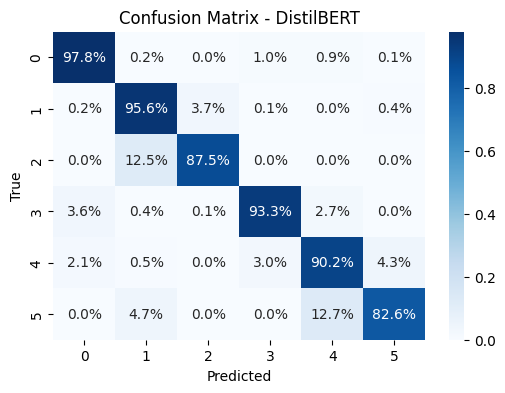

In [48]:
test_dataset = Dataset.from_pandas(test_ds)
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

model = AutoModelForSequenceClassification.from_pretrained("./emotion-classifier")
tokenizer = AutoTokenizer.from_pretrained("./emotion-classifier")

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
)

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

print(
    classification_report(
        test_ds["label"],
        predicted_labels,
        target_names=["sadness", "joy", "love", "anger", "fear", "surprise"],
    )
)

pretrained_accuracy = accuracy_score(test_ds["label"], predicted_labels)
pretrained_f1 = f1_score(test_ds["label"], predicted_labels, average='macro')
print(f"Classification accuracy: {pretrained_accuracy:.3f}")
print(f"F1 score: {pretrained_f1:.3f}")

pretrained_cm = confusion_matrix(test_ds["label"], predicted_labels)
pretrained_cm = pretrained_cm.astype('float') / pretrained_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
sns.heatmap(pretrained_cm, annot=True, fmt='.1%', cmap='Blues', xticklabels=np.unique(test_ds['label']), yticklabels=np.unique(test_ds['label']))
plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Results

#### Basic machine learning results
We used different techinques:
- decision tree (dt)
- naive bayes (nb)
- support vector machine (svm)
- random forest (rf)

*We also compared the performance of these classifiers with both raw and preprocessed text and because models perform better with preprocessed text, we used it on all models.

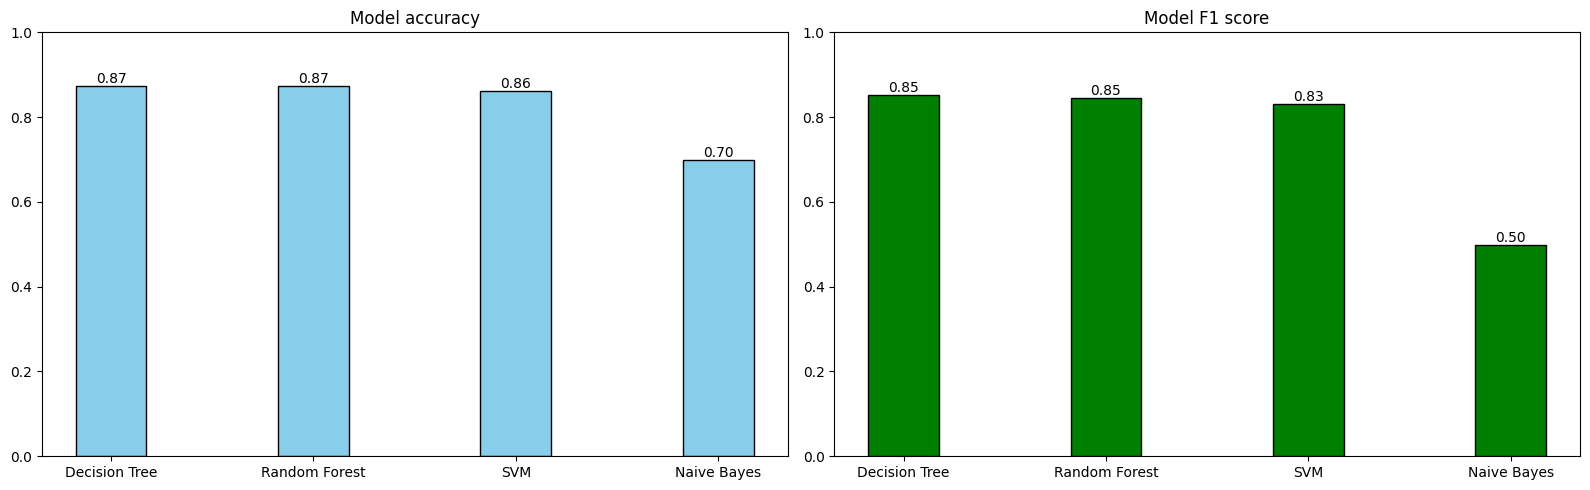

In [49]:
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'Naive Bayes']
small_dataset_accuracies = [dt_accuracy, rf_accuracy, svm_accuracy, nb_accuracy]
small_dataset_f1 = [dt_f1, rf_f1, svm_f1, nb_f1]

x = np.arange(len(model_names)) 
width = 0.35 

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
bars1 = plt.bar(x, small_dataset_accuracies, width, color='skyblue', edgecolor='black')
for bar in bars1:
    plt.text(bar.get_x() + width / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.title('Model accuracy')
plt.xticks(x, model_names) 
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
bars2 = plt.bar(x, small_dataset_f1, width, color='green', edgecolor='black')
for bar in bars2:
    plt.text(bar.get_x() + width / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.title('Model F1 score')
plt.xticks(x, model_names) 
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

As we can see from the graphs both decision tree and random forest have the highest of both types of scores, and naive Bayes classifier has significantly lower scores than the rest.



For decision tree, support vector machine and random forest classifiers we also executed a grid search for the best parameters and here are the results.



In [50]:
dt_best_params = dt_grid_search.best_params_
print("For DECISION TREE search among:")
for key, value in dt_param_grid.items():
    print(f"  {key}: {value}")
print("Best parameters:")
for key, value in dt_best_params.items():
    print(f"  {key}: {value}")

rf_best_params = rf_grid_search.best_params_
print("\nFor RANDOM FOREST search among:")
for key, value in rf_param_grid.items():
    print(f"  {key}: {value}")
print("Best parameters:")
for key, value in rf_best_params.items():
    print(f"  {key}: {value}")

svm_best_params = svm_grid_search.best_params_
print("\nFor SUPPORT VECTOR MACHINE search among:")
for key, value in svm_param_grid.items():
    print(f"  {key}: {value}")
print("Best parameters:")
for key, value in svm_best_params.items():
    print(f"  {key}: {value}")



For DECISION TREE search among:
  max_depth: [None, 5, 10, 20]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
Best parameters:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 10

For RANDOM FOREST search among:
  n_estimators: [50, 100, 200]
  max_depth: [None, 5, 20]
  bootstrap: [True, False]
Best parameters:
  bootstrap: False
  max_depth: None
  n_estimators: 100

For SUPPORT VECTOR MACHINE search among:
  C: [0.1, 1, 10]
  kernel: ['linear', 'rbf']
Best parameters:
  C: 1
  kernel: linear


#### Advanced machine learning
For advanced machine learning we first used a larger data sample (50 000 examples, ten times larger set than the original one) on all the basic machine learning models and then used it also on all other more advanced techniques like:


- bagging
- voting
- boosting
- stacking
- fine-tunning pre-trained model

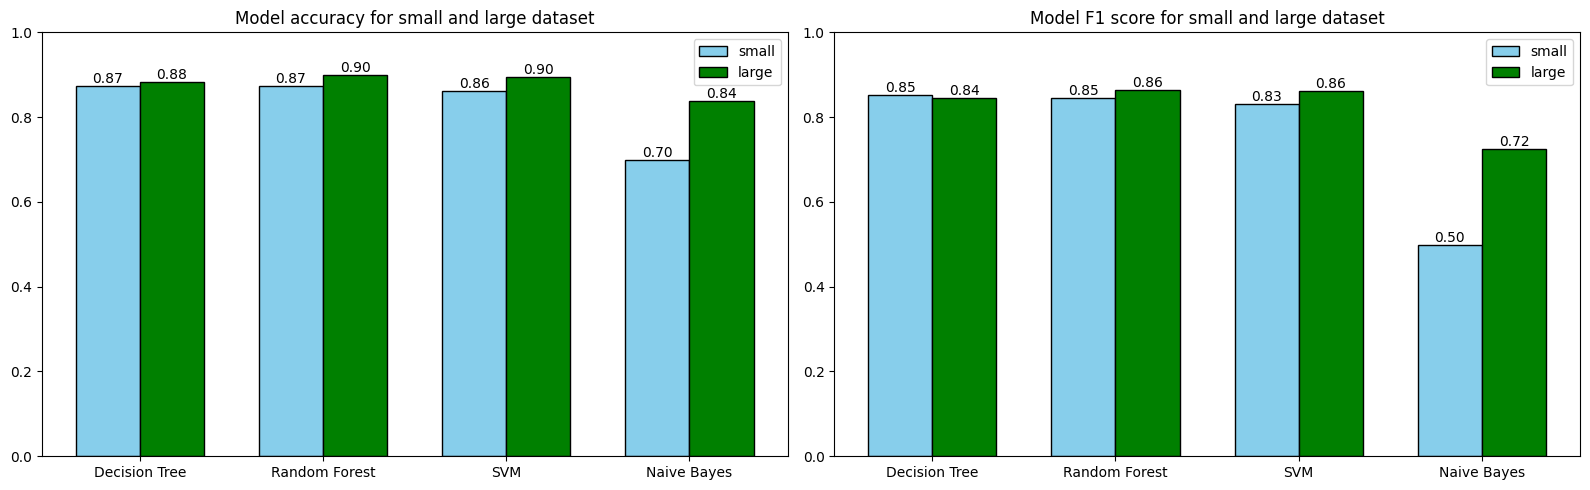

In [51]:
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'Naive Bayes']
small_dataset_accuracies = [dt_accuracy, rf_accuracy, svm_accuracy, nb_accuracy]
small_dataset_f1 = [dt_f1, rf_f1, svm_f1, nb_f1]
big_dataset_accuracies = [dt_big_accuracy, rf_accuracy_big, svm_big_accuracy, nb_big_accuracy]
big_dataset_f1 = [dt_big_f1, rf_f1_big, svm_big_f1, nb_big_f1]

x = np.arange(len(model_names)) 
width = 0.35 

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
bars1 = plt.bar(x - width/2, small_dataset_accuracies, width, label='small', color='skyblue', edgecolor='black')
bars2 = plt.bar(x + width/2, big_dataset_accuracies, width, label='large', color='green', edgecolor='black')
for bar in bars1:
    plt.text(bar.get_x() + width / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
for bar in bars2:
    plt.text(bar.get_x() + width / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.title('Model accuracy for small and large dataset')
plt.xticks(x, model_names) 
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
bars1 = plt.bar(x - width/2, small_dataset_f1, width, label='small', color='skyblue', edgecolor='black')
bars2 = plt.bar(x + width/2, big_dataset_f1, width, label='large', color='green', edgecolor='black')
for bar in bars1:
    plt.text(bar.get_x() + width / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
for bar in bars2:
    plt.text(bar.get_x() + width / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.title('Model F1 score for small and large dataset')
plt.xticks(x, model_names) 
plt.ylim(0, 1)
plt.legend()


plt.tight_layout()
plt.show()

We can see there is an improvement in accuracy and F1 score for all models. The biggest difference is in both scores for Naive Bayes where accuracy improved by 14% and F1 score improved by 22%. One other interesting observation is that on a smaller dataset the random forest and decision tree classifiers were approximately equaly good, but on a larger dataset the random forest classifier improved much more than the decision tree classifier.

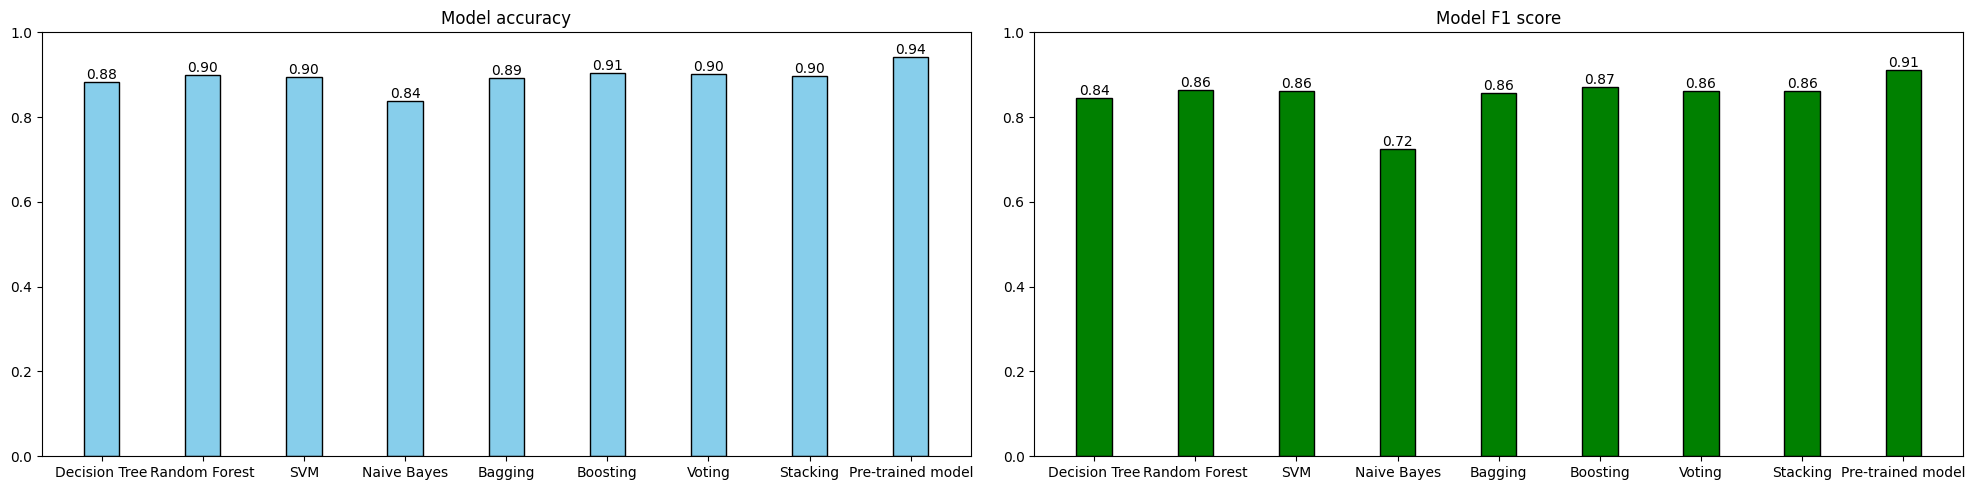

In [52]:
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'Naive Bayes', 'Bagging', 'Boosting', 'Voting', 'Stacking', 'Pre-trained model']
big_dataset_accuracies = [dt_big_accuracy, rf_accuracy_big, svm_big_accuracy, nb_big_accuracy, bagging_accuracy, xgb_accuracy, voting_accuracy, stacking_accuracy, pretrained_accuracy]
big_dataset_f1 = [dt_big_f1, rf_f1_big, svm_big_f1, nb_big_f1, bagging_f1, xgb_f1, voting_f1, stacking_f1, pretrained_f1]

x = np.arange(len(model_names)) 
width = 0.35 

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
bars1 = plt.bar(x, big_dataset_accuracies, width, color='skyblue', edgecolor='black')
for bar in bars1:
    plt.text(bar.get_x() + width / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.title('Model accuracy')
plt.xticks(x, model_names) 
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
bars2 = plt.bar(x, big_dataset_f1, width, color='green', edgecolor='black')
for bar in bars2:
    plt.text(bar.get_x() + width / 2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.title('Model F1 score')
plt.xticks(x, model_names) 
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

For both scores, the best model is the fine-tunned pre-trained model distilBERT, and the worst is naive Bayes. Excluding naive Bayes, the accuracy and F1 scores of all other models differ by less than 7%.



For all the models we also calculated the confusion matrix. By summing them up and normalizing them, we can see which emotions were most frequently mislabeled.



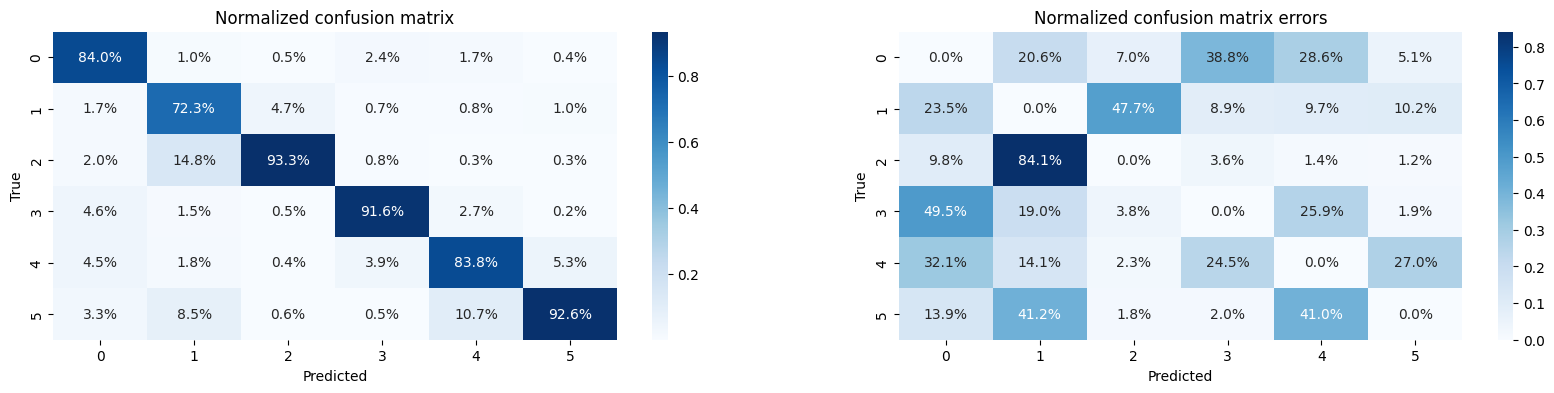

In [66]:
big_dataset_cm = [dt_big_cm, rf_cm_big, svm_big_cm, nb_big_cm, bagging_cm, xgb_cm, voting_cm, stacking_cm, pretrained_cm]
numpy_cm = np.array(big_dataset_cm)

sum_cm = np.sum(numpy_cm, axis=0)
column_sums = np.sum(sum_cm, axis=0)
normalised_cm = sum_cm / column_sums

np.fill_diagonal(sum_cm, 0)
row_sums = np.sum(sum_cm, axis=1, keepdims=True)
normalised_cm_errors = sum_cm / row_sums

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
sns.heatmap(normalised_cm, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=np.unique(test_df['label']), 
            yticklabels=np.unique(test_df['label']))
plt.title(f"Normalized confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(normalised_cm_errors, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=np.unique(test_df['label']), 
            yticklabels=np.unique(test_df['label']))
plt.title(f"Normalized confusion matrix errors")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

First plot shows the normalized confusion matrix, where we can see that emotions with labels 1 - joy and 4 - fear are more frequently mislabeled and emotions 2 - love, 3 - anger, and 5 - surprise are correctly predicted with an accuracy of more than 90%. On the second plot we can see where most errors occured. For example emotion 2 - joy was most frequently mislabeled as emotion 1 - love.